# Import Libraries

In [102]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer


# Read Data

In [78]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
print(f"Dataframe dimensions: {df.shape[0]} rows by {df.shape[1]} columns")
df.head()

Dataframe dimensions: 2240 rows by 29 columns


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Data Cleaning

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Initial Cleanup

From the .info() output above, we can see that there are 3 initial problems with this dataset:
1. 'Income' is missing values
2. 'Dt_Customer' is not stored as DateTime
3. There are a few categorical features in the dataset; some as stored as objects and will need to be converted to numeric

1. ##### Remove NAs

In [79]:
df = df.dropna()
print(f"The new dimensions of the dataset are {df.shape}")

The new dimensions of the dataset are (2216, 29)


2. ##### Convert to DateTime

In [80]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
print(f"The earliest record is {df['Dt_Customer'].min()}\nThe most recent record is {df['Dt_Customer'].max()} ")

The earliest record is 2012-01-08 00:00:00
The most recent record is 2014-12-06 00:00:00 


C:\Users\Kyrie\AppData\Local\Temp\ipykernel_588\1380176463.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


2. ##### Create New Customer Age Feature

In [81]:
baseline = df['Dt_Customer'].max()
df['Cust_Age'] = [baseline - i for i in df['Dt_Customer']]
df['Cust_Age'] = pd.to_numeric(df['Cust_Age'], errors='coerce')

3. ##### Categorical Feature Exploration

In [82]:
print(f"Total Categories in Education:\n{df['Education'].value_counts()}\n")
print(f"Total Categories in Marital Status:\n{df['Marital_Status'].value_counts()}")

Total Categories in Education:
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

Total Categories in Marital Status:
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64


### Feature Engineering

* Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
* Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
* Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating "Family_Size"
* Create a feature "Is_Parent" to indicate parenthood status
* Lastly, I will create three categories in the "Education" by simplifying its value counts.
* Dropping some of the redundant features

In [83]:
# Feature Engineering
# Age of customer today
df['Age'] = 2023 - df['Year_Birth']

# Total spendings on various items
df['Spent'] = df['MntFishProducts'] + df['MntFruits'] + df['MntGoldProds'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

# Rename for readibility
df = df.rename(columns={
    "MntWines": "Wines",
    "MntFruits":"Fruits",
    "MntMeatProducts":"Meat",
    "MntFishProducts":"Fish",
    "MntSweetProducts":"Sweets",
    "MntGoldProds":"Gold"})

# Consolidate marital status
df['Living_With'] = df['Marital_Status'].replace({
    "Married": "Partner",
    "Together": "Partner",
    "Single": "Single",
    "Divorced": "Single",
    "Widow": "Single",
    "Alone": "Single",
    "Absurd": "Single",
    "YOLO": "Single"})

# Create children feature
df['Children'] = df['Kidhome'] + df['Teenhome']

# Calculate total number in household
df['Family_Size'] = df['Living_With'].replace({"Partner":2, "Single":1}) + df['Children']

# Determine if parent
df['Is_Parent'] = np.where(df['Children'] > 0, 1, 0)

# Consolidate education
df['Education'] = df['Education'].replace({
    "Graduation": "Graduate",
    "PhD": "Postgraduate",
    "Master": "Postgraduate",
    "2n Cycle": "Undergraduate",
    "Basic": "Undergraduate"})

# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

Begin exploring values of data

In [84]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cust_Age,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,54.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,27.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,46.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,53.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,64.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,130.000000,2525.000000,3.000000,5.000000,1.000000


### Check for Outlier Values

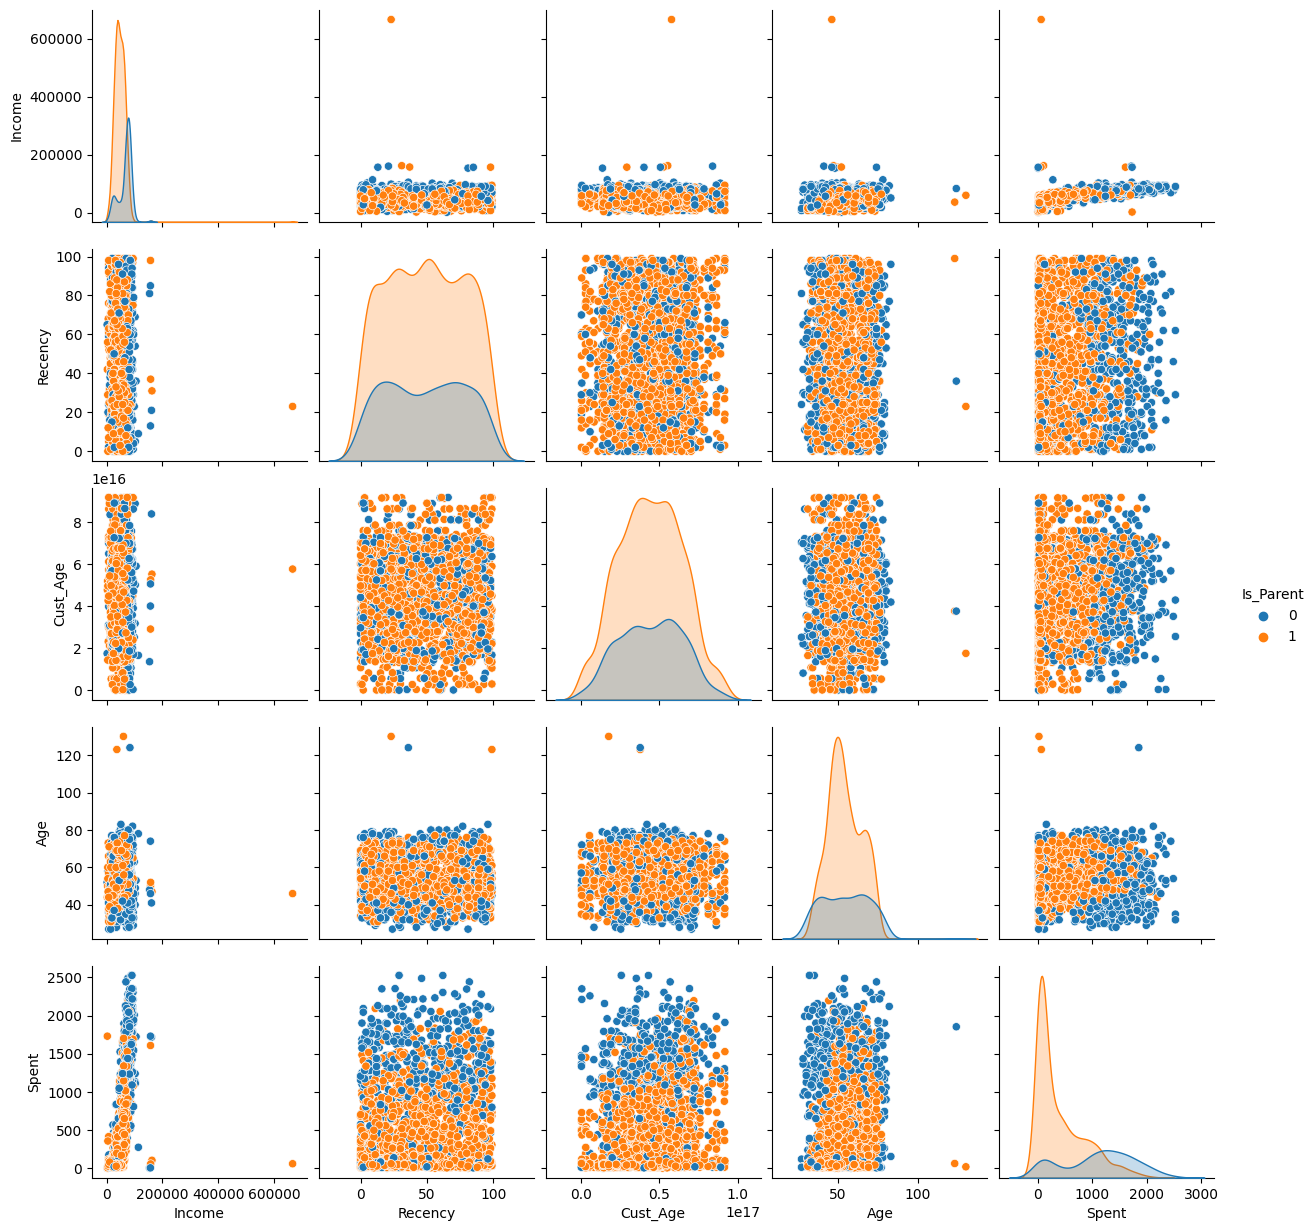

In [85]:
# Arbitrarily choose some features to explore
To_Plot = ["Income", "Recency", "Cust_Age", "Age", "Spent", "Is_Parent"]
sns.pairplot(df[To_Plot], hue='Is_Parent')

We can see that there are a few outliers commonly associated with Age and Income

In [86]:
# Keep rows with age less than 100
df = df[df['Age'] < 100]

# Keep rows with income less than 600000
df = df[df['Income'] < 600000]

print(f"There are now {df.shape[0]} rows of data")

There are now 2212 rows of data


### Check Correlations

C:\Users\Kyrie\AppData\Local\Temp\ipykernel_588\3818127241.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, annot_kws={"size": 5}, cmap="coolwarm")


<AxesSubplot: >

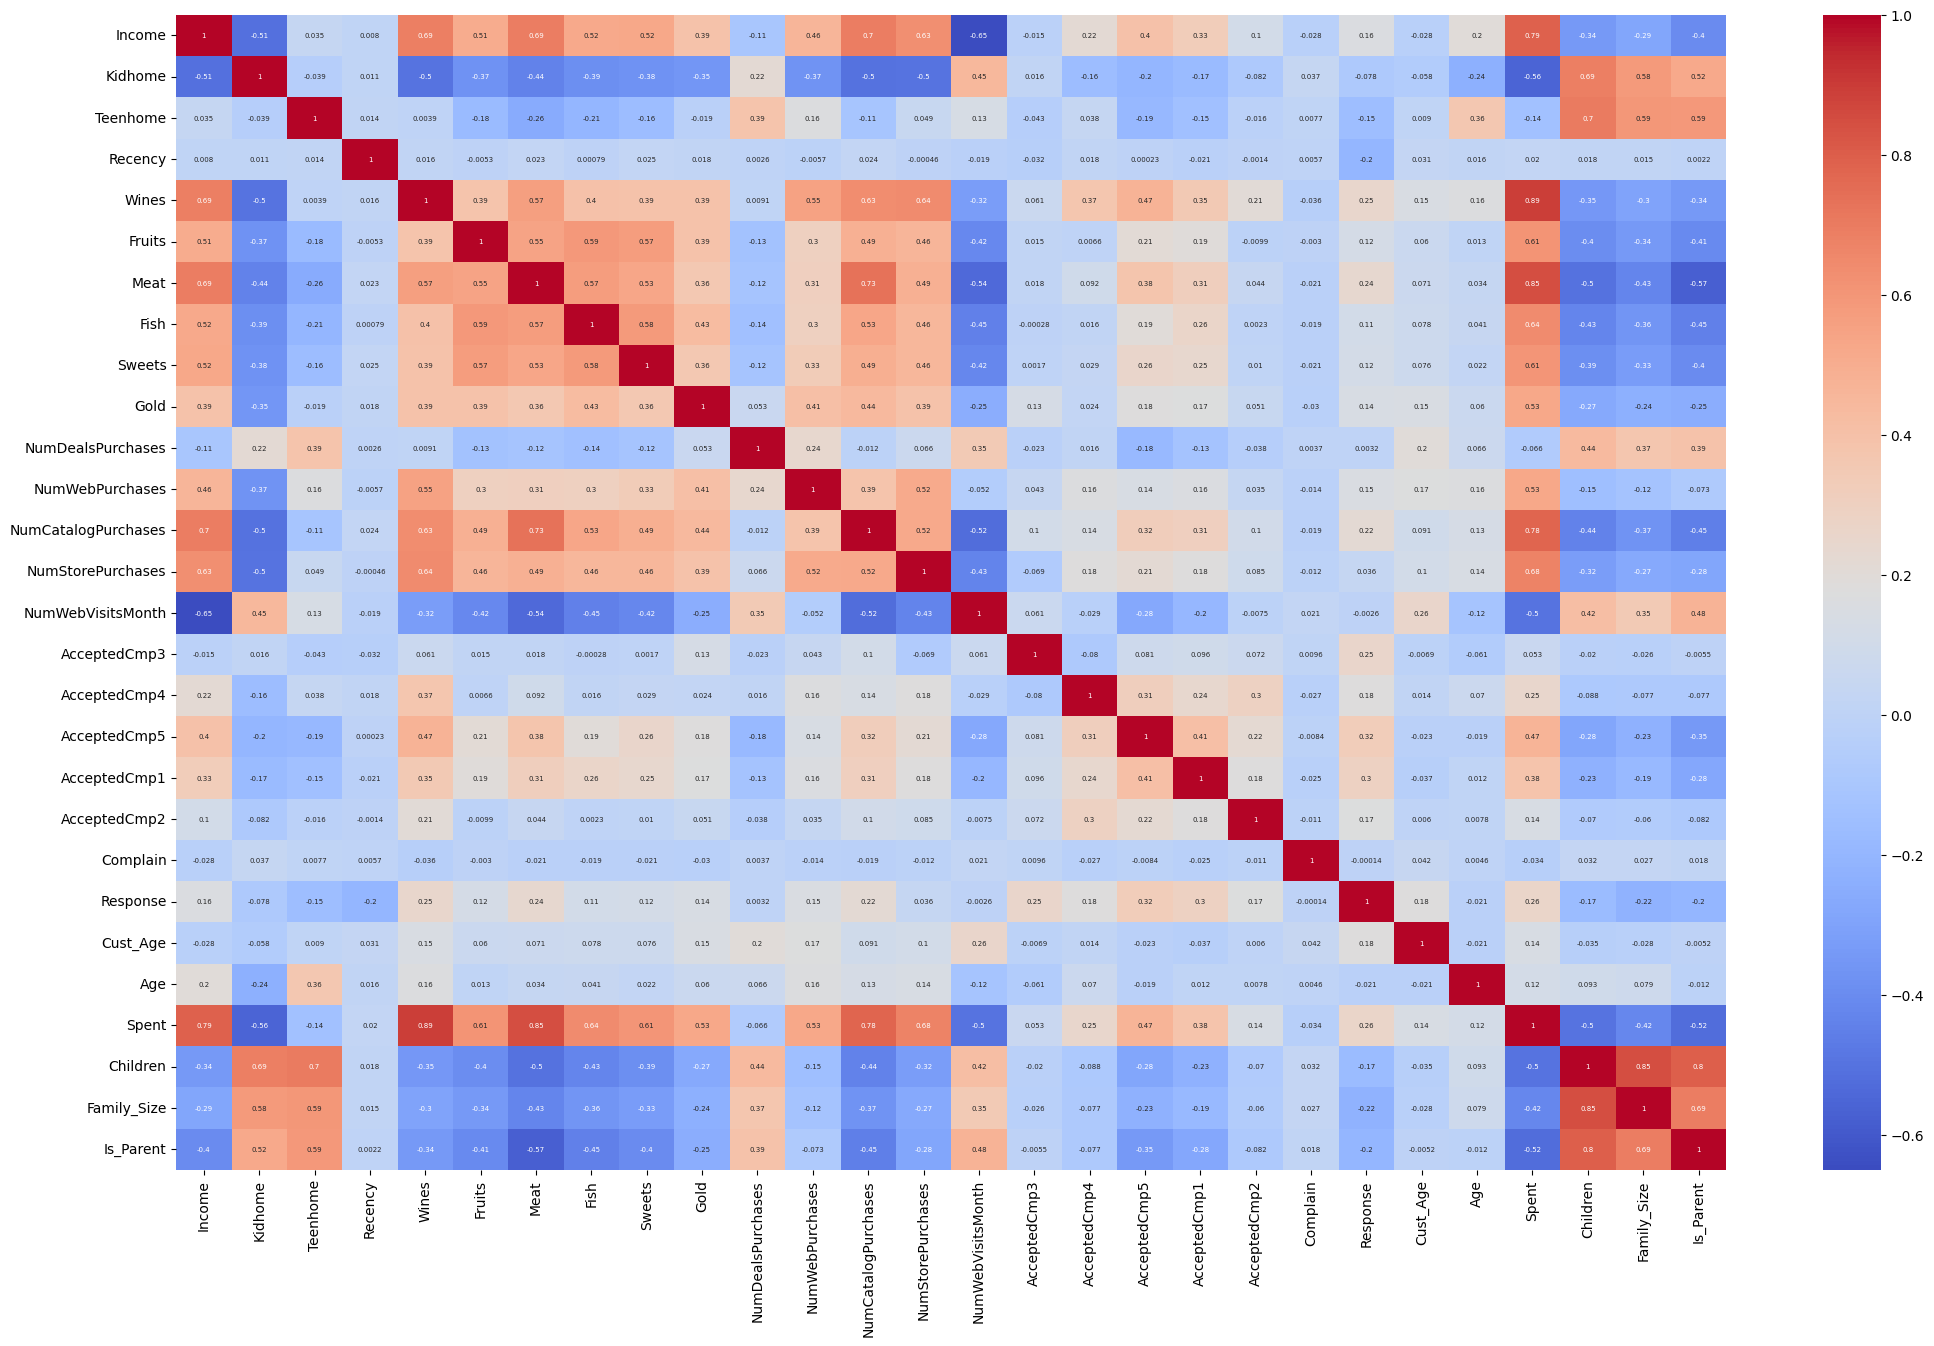

In [87]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 5}, cmap="coolwarm")

There's a slightly high correlation between Wines/Meat and Spent. However, for the most part, this data is very clean

# Data Preprocessing

3 primary steps taken during pre-processing:
1. Encode categorical data
2. Feature scaling using standard scaler
3. Feature selection for dimensionality reduction

In [88]:
# Get a list of categorical variables
s = df.dtypes == 'object'
object_cols = list(s[s].index)

print(f"Categorical variables in dataset: {object_cols}")

Categorical variables in dataset: ['Education', 'Living_With']


In [89]:
# Label Encoding
LE = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)

In [90]:
# Createa a copy of df
ds = df.copy()

# Create a subset of the df with less features
col_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(col_del, axis=1)

# Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [92]:
# Dataframe to be used for future modeling
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Cust_Age,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,-0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,-0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,-0.740959,0.069987,0.449070,0.632456


# Dimensionality Reduction

**Dimensionality Reduction** is a technique for reducing the number of random variables under consideration by obtaining a set of principle variables

**Principle Component Analysis (PCA)** is a technique for dimensionality reduction which enables us to create principle composites that best represent the variables under less complexity and low information loss

**Steps in this Section**
* Dimensionality reduction using PCA
* Plotting the reduced dataframe

In [94]:
# Initiating dimensioanlity reduction to 3 features (convenient for graphing)
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['col1','col2','col3']))
PCA_ds.describe()

,col1,col2,col3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,-2.377042e-16,-7.066881e-17,6.825964e-17
std,2.878377e+00,1.706839e+00,1.221956e+00
min,-5.969394e+00,-4.312167e+00,-3.531093e+00
25%,-2.538494e+00,-1.328331e+00,-8.288588e-01
50%,-7.804209e-01,-1.581446e-01,-2.117643e-02
75%,2.383290e+00,1.242281e+00,7.989890e-01
max,7.444305e+00,6.142748e+00,6.619856e+00


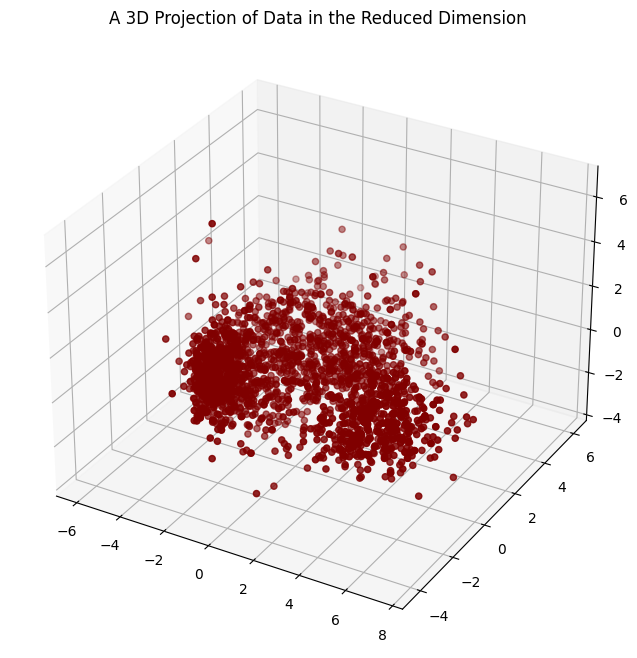

In [96]:
# 3D Projection of new model
x, y, z = PCA_ds['col1'], PCA_ds['col2'], PCA_ds['col3']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c="maroon", marker="o")
ax.set_title("A 3D Projection of Data in the Reduced Dimension")
plt.show()

# Clustering

**Steps Involved with Clustering** 

* Elbow Method to determine number of clusters
* Clustering via Agglomerative Clustering
* Examining clusters formed via scatter plot

**Agglomerative Clustering**: a type of heirarchical clustering algorithm in unsupervised ML that divides data into like clusters based on euclidean distance

c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

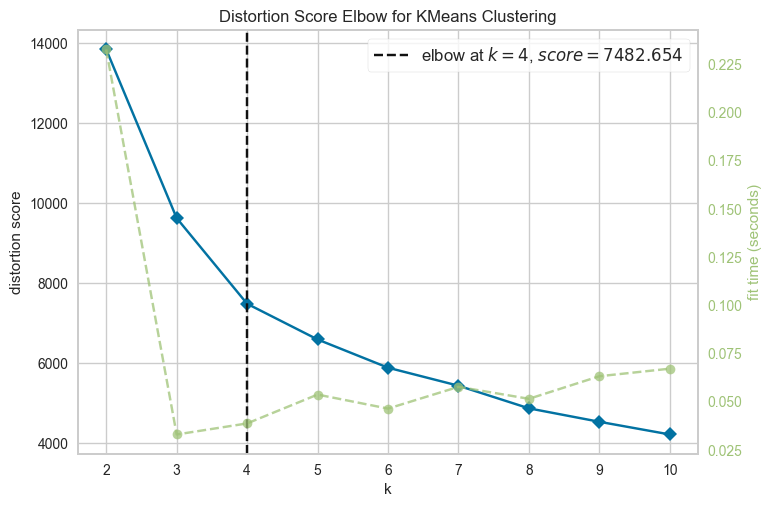

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [98]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The elbow plot shows that 4 is the optimal number of clusters. It's time to fit an Agglomerative Clustering Model to get the final clusters

In [99]:
# Initiate Agglomerative Clustering Model
AC = AgglomerativeClustering(n_clusters=4)

# Fit model
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds['Clusters'] = yhat_AC

# Add clusters to original dataframe df
df['Clusters'] = yhat_AC

To examine clusters, create a 3-D render of clusters

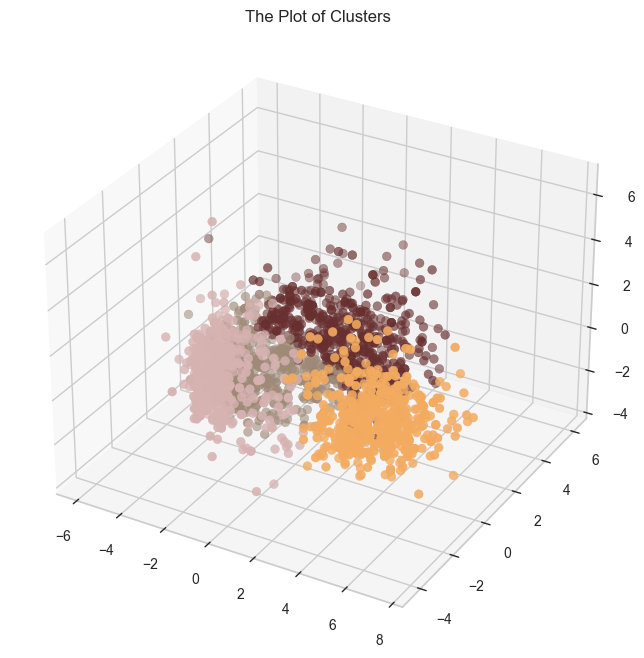

In [103]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
cmap = ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
ax.scatter(x,y,z, s=40, c=PCA_ds['Clusters'], marker='o', cmap=cmap)
ax.set_title("The Plot of Clusters")
plt.show()

# Model Evaluation

Since this is an unsupervised clustering method, we don't have a tagged feature to score the model. This section will be used to study the patterns in the clusters formed and determine the nature of the clusters' patterns

Essentially, we're gonna perform EDA to draw some conslusions

##### Clustering Distribution

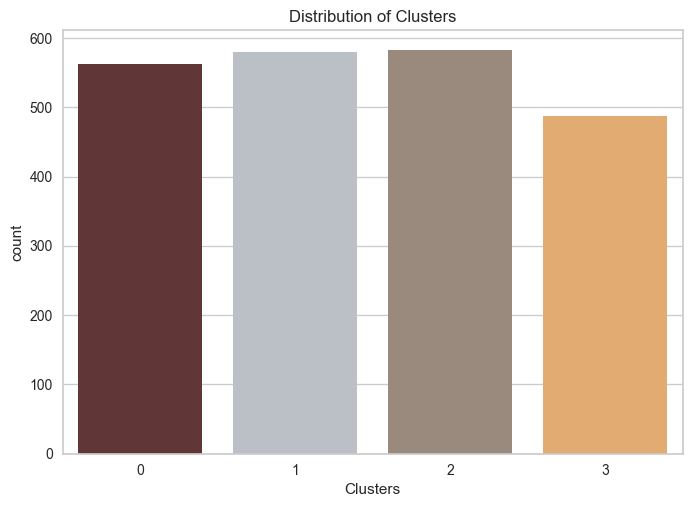

In [108]:
# Count
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df['Clusters'], palette=pal)
pl.set_title("Distribution of Clusters")
plt.show()

There is a very even distribution of clusters

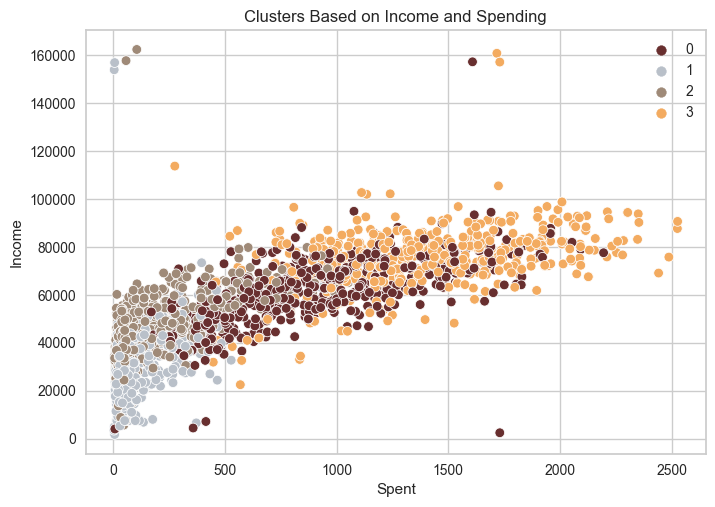

In [109]:
# Income vs Spending
pl = sns.scatterplot(x=df['Spent'], y=df['Income'], hue=df['Clusters'], palette=pal)
pl.set_title("Clusters Based on Income and Spending")
plt.legend()
plt.show()

Spening vs Income Cluster Patterns:

| Group | Description |
|---|---|
| 0 | Medium spending, medium income |
| 1 | Low spending, low income |
| 2 | Low spending, medium income |
| 3 | High spending, high income |

c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 69.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

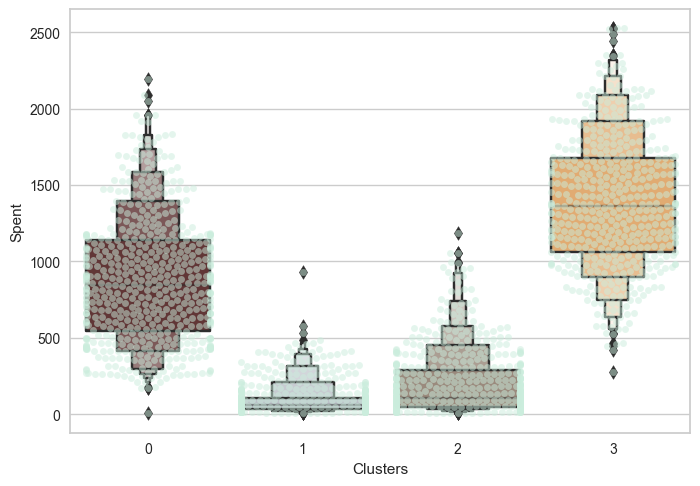

In [111]:
plt.figure()
pl = sns.swarmplot(x=df['Clusters'], y=df['Spent'], color='#CBEDDD', alpha=0.5)
pl = sns.boxenplot(x=df['Clusters'], y=df['Spent'], palette=pal)
plt.show()

We can clearly see that group 3 is the largest set of customers, followed by group 0. We should explore what each group is spending on to determine ideal marketing strategies

Explore how promotional campaigns performed in the past amongst groups

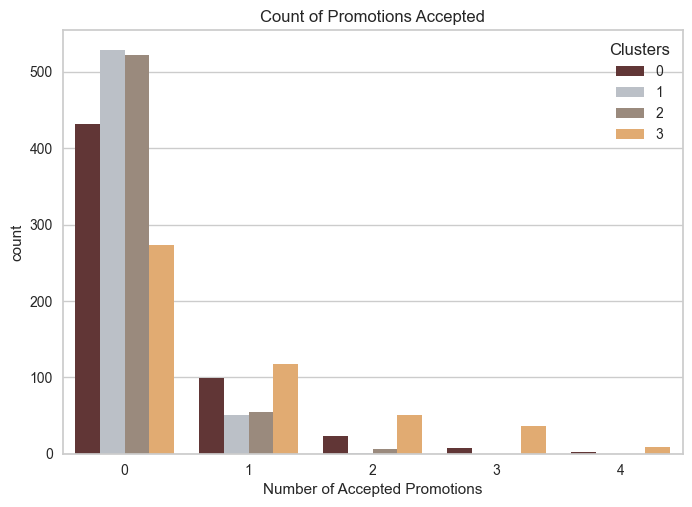

In [113]:
df['Total_Promos'] = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']
plt.figure()
pl = sns.countplot(x=df['Total_Promos'], hue=df['Clusters'], palette=pal)
pl.set_title("Count of Promotions Accepted")
pl.set_xlabel("Number of Accepted Promotions")
plt.show()

We can see that promotions have not been very effective in the past. The majority of customers did not accept any promotion. Furthermore, not a single customer accepted all 5 promotional campaigns. Promos should be redesigned or shut down in the future

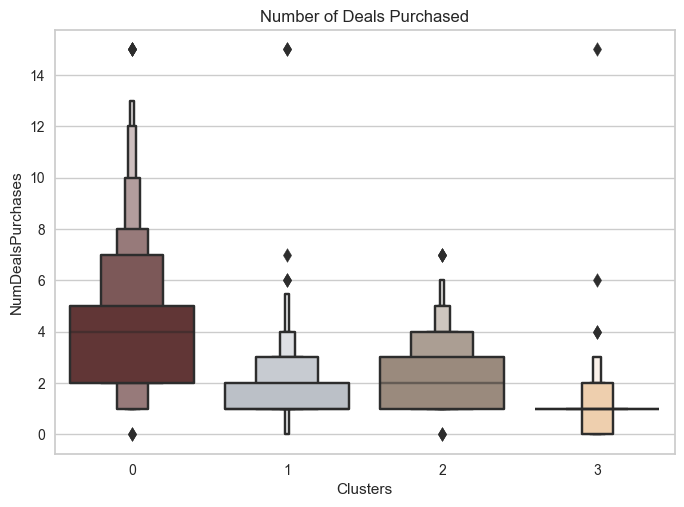

In [115]:
# Check out number of deals purchased
plt.figure()
pl = sns.boxenplot(y=df['NumDealsPurchases'], x=df['Clusters'], palette=pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Group 0 seems to have been responsive to deals, however group 3 is not. This may be attributable to group 3 having a higher income and not worrying about spending, but that is speculation. Moreover, we can see that groups 1 and 2 (the low spenders with low and medium income, respectively) show little response to deals.

# Profiling

Now that we've formed clusters and explored purchsing habits, let's dive deeper into who is represented by these clusters to determine who are start customers and who needs more attention.

First, explore personal characteristics that may be indiciative of these customers

In [116]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Cust_Age',
       'Age', 'Spent', 'Living_With', 'Children', 'Family_Size', 'Is_Parent',
       'Clusters', 'Total_Promos'],
      dtype='object')

<Figure size 800x550 with 0 Axes>

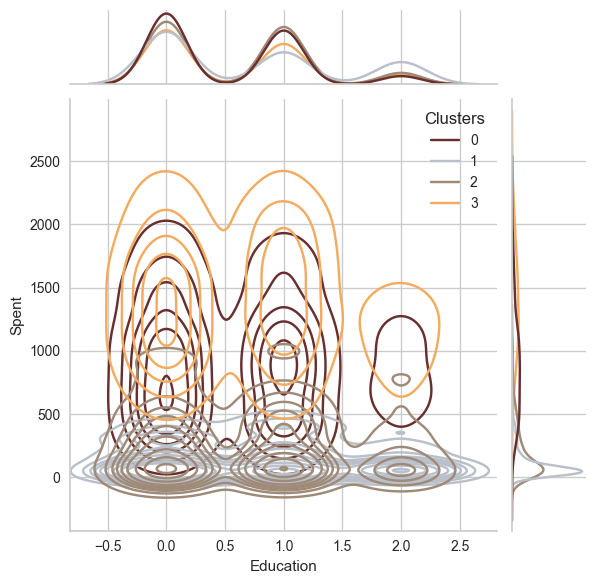

<Figure size 800x550 with 0 Axes>

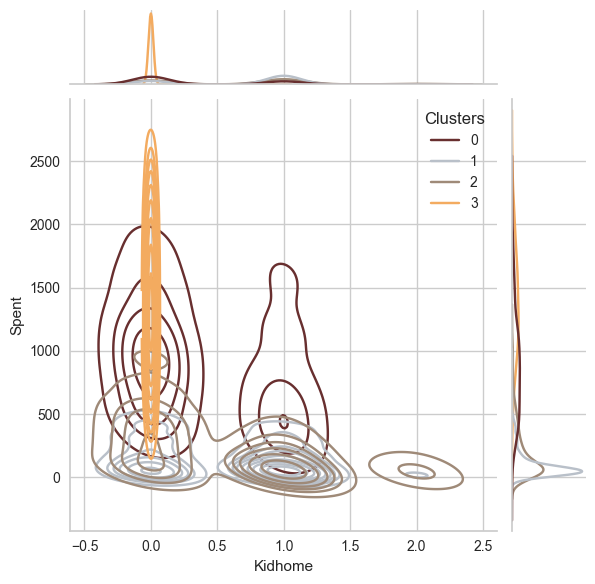

c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

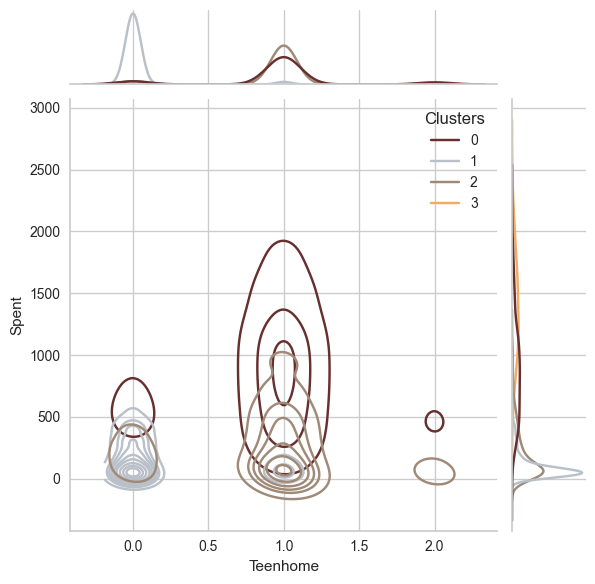

<Figure size 800x550 with 0 Axes>

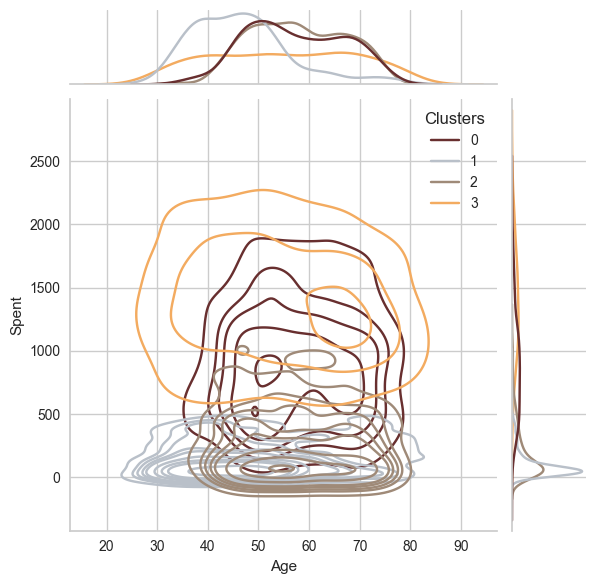

<Figure size 800x550 with 0 Axes>

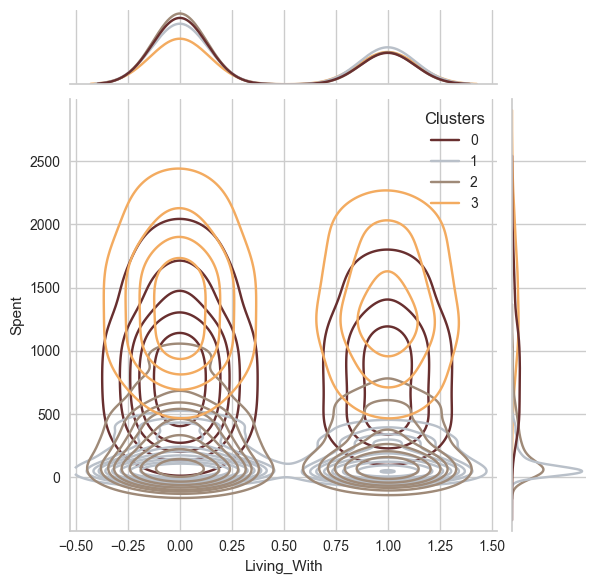

<Figure size 800x550 with 0 Axes>

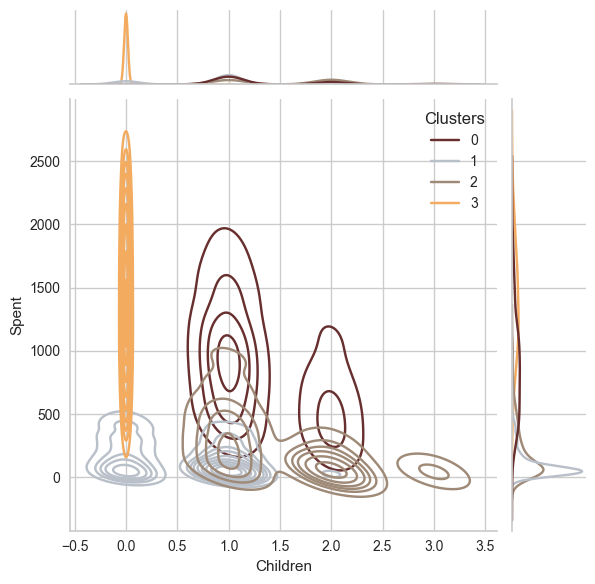

<Figure size 800x550 with 0 Axes>

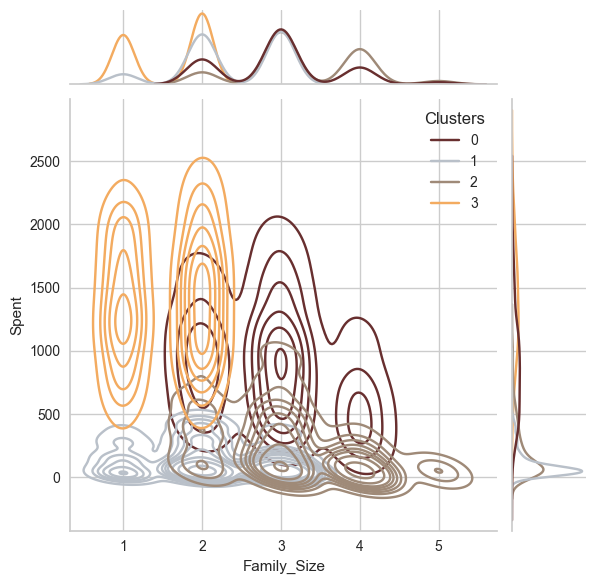

c:\Users\Kyrie\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

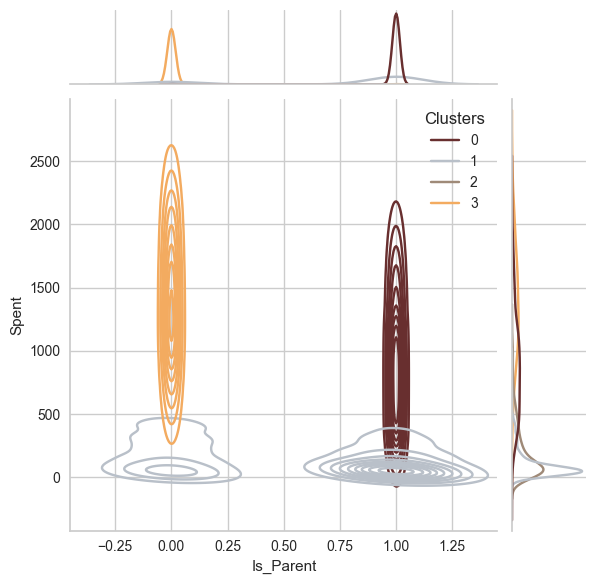

<Figure size 800x550 with 0 Axes>

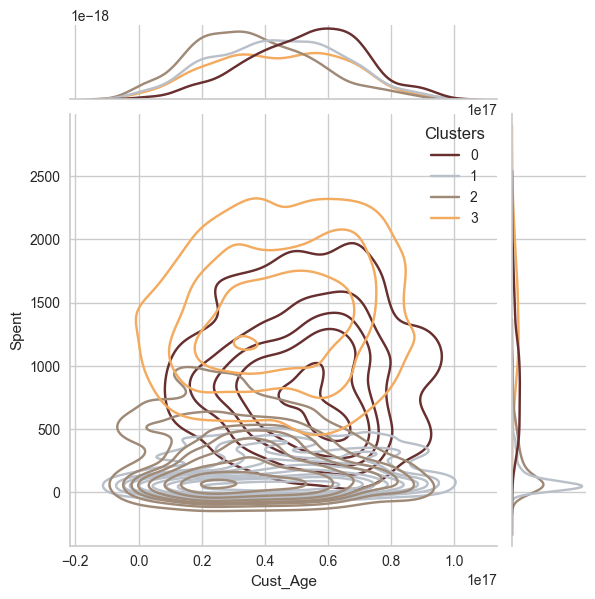

In [117]:
Personal = ['Education', 'Kidhome', 'Teenhome', 'Age', 'Living_With', 'Children', 'Family_Size', 'Is_Parent', 'Cust_Age']

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df['Spent'], hue=df['Clusters'], palette=pal, kind='kde')
    plt.show()

### About Cluster Number 0:
* Definitely a parent
* Family size between 2-4
* Includes single parents
* Kids and teens at home
* Age range older (40-80)

### About Cluster Number 1:
* Most are parents
* Family size between 1-3
* Includes single parents
* Primarily one kid and no teens
* Relatively younger (30-70)

### About Cluster Number 2:
* Definitely a parent
* Family size between 2-5
* Includes single parents
* Most have 1 kid and 1 teen
* Age range older (40-80)

### About Cluster Number 3:
* Definitely not a parent
* Family size between 1-2
* Includes single and married
* No kids, no teens
* Wide age range (30-80)